# Theme 4 - Coastal Ocean Dynamics and Ecosystems
## Shelf/Slope Exchange
OOI Data Labs Education Nuggets

_Written by Lori Garzio, Rutgers University_

**Objective**: Demonstrate how to download data from two Pioneer profilers using the Machine-to-Machine (M2M) interface, calculate depth-binned hourly averages, and export the data as a .csv file.

In [1]:
# Notebook Setup
import requests
import os
import re
import xarray as xr
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

## 1. Request Data from OOINet

* **Coastal Pioneer Central Offshore Profiler Mooring** - CTD, fluorometer, and dissolved oxygen
    * Instruments, data streams, parameters:
        * CP02PMCO-WFP01-03-CTDPFK000
            * ctdpf_ckl_wfp_instrument_recovered: ctdpf_ckl_seawater_pressure, ctdpf_ckl_seawater_temperature, practical_salinity
        * CP02PMCO-WFP01-04-FLORTK000
            * flort_sample: pressure_depth, fluorometric_cdom
        * CP02PMCO-WFP01-02-DOFSTK000
            * dofst_k_wfp_instrument_recovered: dofst_k_oxygen_l2
* **Coastal Pioneer Offshore Profiler Mooring** - CTD, fluorometer, and dissolved oxygen
    * Instruments, data streams, parameters:
        * CP04OSPM-WFP01-03-CTDPFK000
            * ctdpf_ckl_wfp_instrument_recovered: ctdpf_ckl_seawater_pressure, ctdpf_ckl_seawater_temperature, practical_salinity
        * CP04OSPM-WFP01-04-FLORTK000
            * flort_sample: int_ctd_pressure, fluorometric_cdom
        * CP04OSPM-WFP01-02-DOFSTK000
            * dofst_k_wfp_instrument_recovered: int_ctd_pressure, dofst_k_oxygen_l2
* **Time range**: 2014-06-13 to 2014-06-21
* **Delivery method**: recovered_wfp

The **request_data** function below sends data requests with inputs specified by the user to OOINet and returns the THREDDs urls where the downloaded data files can be found.

In [2]:
# enter your OOI API username and token, and directory where output .csv files are saved
API_USERNAME = ''
API_TOKEN = ''
save_dir = '/Users/lgarzio/Documents/OOI/Nuggets/'

In [3]:
def request_data(reference_designator, method, stream, start_date=None, end_date=None):
    site = reference_designator[:8]
    node = reference_designator[9:14]
    instrument = reference_designator[15:]

    # Create the request URL
    api_base_url = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv'
    data_request_url = '/'.join((api_base_url, site, node, instrument, method, stream))

    # All of the following are optional, but you should specify a date range
    params = {
        'format': 'application/netcdf',
        'include_provenance': 'true',
        'include_annotations': 'true'
    }
    if start_date:
        params['beginDT'] = start_date
    if end_date:
        params['endDT'] = end_date

    # Make the data request
    r = requests.get(data_request_url, params=params, auth=(API_USERNAME, API_TOKEN))
    data = r.json()

    # Return just the THREDDS URL
    return data['allURLs'][0]

Now, use that **request_data** function to download data you want. You only need to do this once! These lines are commented out to prevent accidental re-submission of data requests.

In [4]:
# CTD_central_url = request_data('CP02PMCO-WFP01-03-CTDPFK000', 'recovered_wfp', 'ctdpf_ckl_wfp_instrument_recovered',
#                                '2014-06-13T00:00:00.000Z', '2014-06-21T00:00:00.000Z')

# CTD_off_url = request_data('CP04OSPM-WFP01-03-CTDPFK000', 'recovered_wfp', 'ctdpf_ckl_wfp_instrument_recovered',
#                            '2014-06-13T00:00:00.000Z', '2014-06-21T00:00:00.000Z')

# FLORT_central_url = request_data('CP02PMCO-WFP01-04-FLORTK000', 'recovered_wfp', 'flort_sample',
#                                  '2014-06-13T00:00:00.000Z', '2014-06-21T00:00:00.000Z')

# FLORT_off_url = request_data('CP04OSPM-WFP01-04-FLORTK000', 'recovered_wfp', 'flort_sample',
#                              '2014-06-13T00:00:00.000Z', '2014-06-21T00:00:00.000Z')

# DO_central_url = request_data('CP02PMCO-WFP01-02-DOFSTK000', 'recovered_wfp', 'dofst_k_wfp_instrument_recovered',
#                               '2014-06-13T00:00:00.000Z', '2014-06-21T00:00:00.000Z')

# DO_off_url = request_data('CP04OSPM-WFP01-02-DOFSTK000', 'recovered_wfp', 'dofst_k_wfp_instrument_recovered',
#                           '2014-06-13T00:00:00.000Z', '2014-06-21T00:00:00.000Z')

# print('CTD_central_url: %s' %CTD_central_url)
# print('CTD_offshore_url: %s' %CTD_off_url)
# print('FLORT_central_url: %s' %FLORT_central_url)
# print('FLORT_offshore_url: %s' %FLORT_off_url)
# print('DO_central_url: %s' %DO_central_url)
# print('DO_offshore_url: %s' %DO_off_url)

## 2. Load Data Files

Copy the links to the THREDDs catalog above that resulted from the **request_data** function (to avoid re-requesting the data). Note: the urls must be surrounded by quotations. Depending on the data request, it may take several minutes for the request to fulfill. The request is complete when you receive an email from the system with the link to your data, and a status.txt file shows up in the THREDDs catalog that says "Complete".

In [5]:
CTD_central_url = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/lgarzio@marine.rutgers.edu/20191104T150259297Z-CP02PMCO-WFP01-03-CTDPFK000-recovered_wfp-ctdpf_ckl_wfp_instrument_recovered/catalog.html'
CTD_off_url = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/lgarzio@marine.rutgers.edu/20191104T150259680Z-CP04OSPM-WFP01-03-CTDPFK000-recovered_wfp-ctdpf_ckl_wfp_instrument_recovered/catalog.html'
FLORT_central_url = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/lgarzio@marine.rutgers.edu/20191104T150259936Z-CP02PMCO-WFP01-04-FLORTK000-recovered_wfp-flort_sample/catalog.html'
FLORT_off_url = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/lgarzio@marine.rutgers.edu/20191104T150300284Z-CP04OSPM-WFP01-04-FLORTK000-recovered_wfp-flort_sample/catalog.html'
DO_central_url = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/lgarzio@marine.rutgers.edu/20191104T150300510Z-CP02PMCO-WFP01-02-DOFSTK000-recovered_wfp-dofst_k_wfp_instrument_recovered/catalog.html'
DO_off_url = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/lgarzio@marine.rutgers.edu/20191104T150300688Z-CP04OSPM-WFP01-02-DOFSTK000-recovered_wfp-dofst_k_wfp_instrument_recovered/catalog.html'

The **get_data** function below:
* selects the appropriate datasets in a THREDDs catalog by selecting NetCDF files, removing collocated datasets (if provided), and removing deployments that aren't specified (if provided)
* creates an empty dictionary with placeholders to populate with data just for variables of interest
* creates another dictionary to store the units for the variables of interest
* opens the dataset(s), extracts the data and units for the variables of interest and adds them to the dictionaries
* converts the data dictionary to a dataframe
* returns the dataframe and the dictionary containing the variable units. 

This type of function is most useful when working with multiple large/dense datasets, but is also fine for working with smaller datasets.

In [6]:
def get_data(url, variables, deployments=None):
    # Function to grab all data from specified directory
    tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'
    dataset = requests.get(url).text
    ii = re.findall(r'href=[\'"]?([^\'" >]+)', dataset)
    # x = re.findall(r'(ooi/.*?.nc)', dataset)
    x = [y for y in ii if y.endswith('.nc')]
    for i in x:
        if i.endswith('.nc') == False:
            x.remove(i)
    for i in x:
        try:
            float(i[-4])
        except:
            x.remove(i)
    # dataset = [os.path.join(tds_url, i) for i in x]
    datasets = [os.path.join(tds_url, i.split('=')[-1]) for i in x]

    # remove deployments not in deployment list, if given
    if deployments is not None:
        deploy = ['deployment{:04d}'.format(j) for j in deployments]
        datasets = [k for k in datasets if k.split('/')[-1].split('_')[0] in deploy]

    # remove collocated data files if necessary
    catalog_rms = url.split('/')[-2][20:]
    selected_datasets = []
    for d in datasets:
        if catalog_rms == d.split('/')[-1].split('_20')[0][15:]:
            selected_datasets.append(d)

    # create a dictionary to populate with data from the selected datasets
    data_dict = {'time': np.array([], dtype='datetime64[ns]')}
    unit_dict = {}
    for v in variables:
        data_dict.update({v: np.array([])})
        unit_dict.update({v: []})
    print('Appending data from files')

    for sd in selected_datasets:
        ds = xr.open_dataset(sd, mask_and_scale=False)
        data_dict['time'] = np.append(data_dict['time'], ds['time'].values)
        for var in variables:
            data_dict[var] = np.append(data_dict[var], ds[var].values)
            units = ds[var].units
            if units not in unit_dict[var]:
                unit_dict[var].append(units)

    # convert dictionary to a dataframe
    df = pd.DataFrame(data_dict)
    df.sort_values(by=['time'], inplace=True)  # make sure the timestamps are in ascending order

    return df, unit_dict

Now we can specify the variables of interest and get the data for the datasets.

In [7]:
# Specify the variable(s) of interest and get the data for the three datasets
CTD_vars = ['ctdpf_ckl_seawater_pressure', 'ctdpf_ckl_seawater_temperature', 'practical_salinity']
FLORT_vars = ['int_ctd_pressure', 'fluorometric_cdom']
DO_vars = ['int_ctd_pressure', 'dofst_k_oxygen_l2']

CTD_central_data, CTD_central_units = get_data(CTD_central_url, CTD_vars)
CTD_off_data, CTD_off_units = get_data(CTD_off_url, CTD_vars)
FLORT_central_data, FLORT_central_units = get_data(FLORT_central_url, FLORT_vars)
FLORT_off_data, FLORT_off_units = get_data(FLORT_off_url, FLORT_vars)
DO_central_data, DO_central_units = get_data(DO_central_url, DO_vars)
DO_off_data, DO_off_units = get_data(DO_off_url, DO_vars)
print(CTD_central_units)
print(FLORT_central_units)
print(DO_central_units)

Appending data from files
Appending data from files
Appending data from files
Appending data from files
Appending data from files
Appending data from files
{'ctdpf_ckl_seawater_pressure': ['dbar'], 'ctdpf_ckl_seawater_temperature': ['ºC'], 'practical_salinity': ['1']}
{'int_ctd_pressure': ['dbar'], 'fluorometric_cdom': ['ppb']}
{'int_ctd_pressure': ['dbar'], 'dofst_k_oxygen_l2': ['µmol kg-1']}


## Quick Data Plots
First, make some quick plots to make sure you downloaded the correct data.

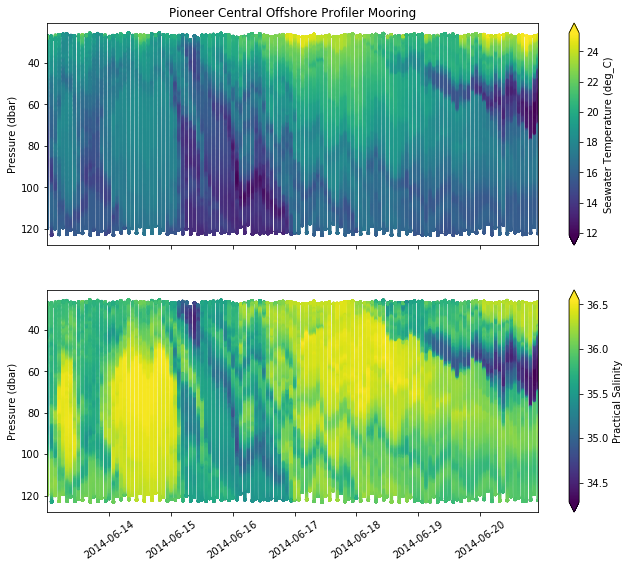

In [8]:
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, figsize=(11,9))
xc1 = ax1.scatter(np.array(CTD_central_data['time']), CTD_central_data['ctdpf_ckl_seawater_pressure'], c=CTD_central_data['ctdpf_ckl_seawater_temperature'], s=5)
ax1.invert_yaxis()
ax1.set_xlabel('')
ax1.set_ylabel('Pressure (dbar)')
bar = fig.colorbar(xc1, ax=ax1, label='Seawater Temperature (deg_C)', extend='both')
ax1.set_title('Pioneer Central Offshore Profiler Mooring')

xc2 = ax2.scatter(np.array(CTD_central_data['time']), CTD_central_data['ctdpf_ckl_seawater_pressure'], c=CTD_central_data['practical_salinity'], s=5)
ax2.invert_yaxis()
ax2.set_xlabel('')
ax2.set_ylabel('Pressure (dbar)')
bar = fig.colorbar(xc2, ax=ax2, label='Practical Salinity', extend='both')
plt.xticks(rotation=35)
# set the x limits to the min and max timestamp to get rid of extra white space in the graph
plt.xlim([np.nanmin(CTD_central_data['time']), np.nanmax(CTD_central_data['time'])]);

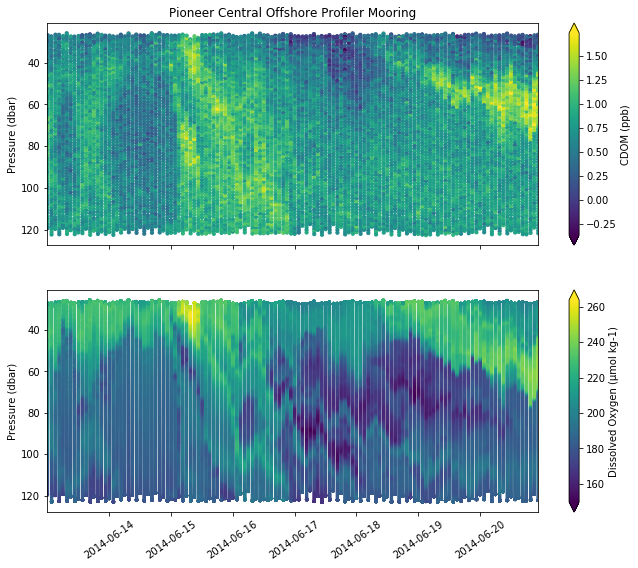

In [9]:
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, figsize=(11,9))
xc1 = ax1.scatter(np.array(FLORT_central_data['time']), FLORT_central_data['int_ctd_pressure'], c=FLORT_central_data['fluorometric_cdom'], s=10)
ax1.invert_yaxis()
ax1.set_xlabel('')
ax1.set_ylabel('Pressure (dbar)')
bar = fig.colorbar(xc1, ax=ax1, label='CDOM ({})'.format(FLORT_central_units['fluorometric_cdom'][0]), extend='both')
ax1.set_title('Pioneer Central Offshore Profiler Mooring')

xc2 = ax2.scatter(np.array(DO_central_data['time']), DO_central_data['int_ctd_pressure'], c=DO_central_data['dofst_k_oxygen_l2'], s=5)
ax2.invert_yaxis()
ax2.set_xlabel('')
ax2.set_ylabel('Pressure (dbar)')
bar = fig.colorbar(xc2, ax=ax2, label='Dissolved Oxygen ({})'.format(DO_central_units['dofst_k_oxygen_l2'][0]), extend='both')
plt.xticks(rotation=35)
# set the x limits to the min and max timestamp to get rid of extra white space in the graph
plt.xlim([np.nanmin(DO_central_data['time']), np.nanmax(DO_central_data['time'])]);

It looks like there are some negative CDOM values. These are within the noise range of the instrument but are invalid, so let's get rid of values less than zero with the function below and replot.

In [10]:
# this function can only be used if the expected values are always >0
def remove_zeros(df, variables):
    cnames = []
    for v in variables:
        if 'm_gps_' not in v:
            cname = v + '_ind'
            cnames.append(cname)
            df[cname] = df[v] > 0.00
    for cn in cnames:
        df = df.loc[df[cn] == True]
    df = df.drop(columns=cnames)
    return df

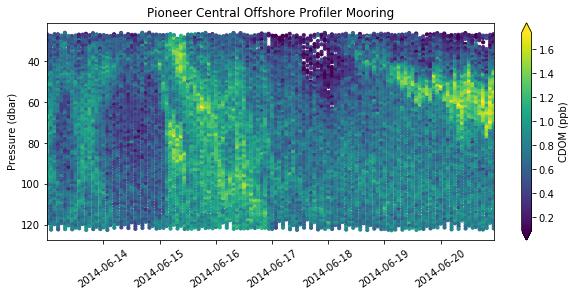

In [11]:
FLORT_central_data = remove_zeros(FLORT_central_data, FLORT_vars)

fig, ax1 = plt.subplots(figsize=(10,4))
xc1 = ax1.scatter(np.array(FLORT_central_data['time']), FLORT_central_data['int_ctd_pressure'], c=FLORT_central_data['fluorometric_cdom'], s=10)
ax1.invert_yaxis()
ax1.set_xlabel('')
ax1.set_ylabel('Pressure (dbar)')
bar = fig.colorbar(xc1, ax=ax1, label='CDOM ({})'.format(FLORT_central_units['fluorometric_cdom'][0]), extend='both')
ax1.set_title('Pioneer Central Offshore Profiler Mooring')
plt.xticks(rotation=35)
# set the x limits to the min and max timestamp to get rid of extra white space in the graph
plt.xlim([np.nanmin(FLORT_central_data['time']), np.nanmax(FLORT_central_data['time'])]);

Let's plot the Offshore Profiler Mooring data.

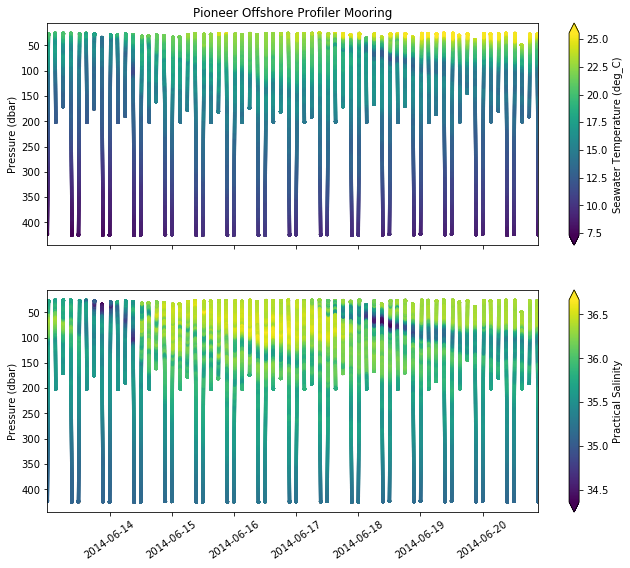

In [12]:
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, figsize=(11,9))
xc1 = ax1.scatter(np.array(CTD_off_data['time']), CTD_off_data['ctdpf_ckl_seawater_pressure'], c=CTD_off_data['ctdpf_ckl_seawater_temperature'], s=5)
ax1.invert_yaxis()
ax1.set_xlabel('')
ax1.set_ylabel('Pressure (dbar)')
bar = fig.colorbar(xc1, ax=ax1, label='Seawater Temperature (deg_C)', extend='both')
ax1.set_title('Pioneer Offshore Profiler Mooring')

xc2 = ax2.scatter(np.array(CTD_off_data['time']), CTD_off_data['ctdpf_ckl_seawater_pressure'], c=CTD_off_data['practical_salinity'], s=5)
ax2.invert_yaxis()
ax2.set_xlabel('')
ax2.set_ylabel('Pressure (dbar)')
bar = fig.colorbar(xc2, ax=ax2, label='Practical Salinity', extend='both')
plt.xticks(rotation=35)
# set the x limits to the min and max timestamp to get rid of extra white space in the graph
plt.xlim([np.nanmin(CTD_off_data['time']), np.nanmax(CTD_off_data['time'])]);

This profiler looks like it does a deep dive once every 3 profiles.

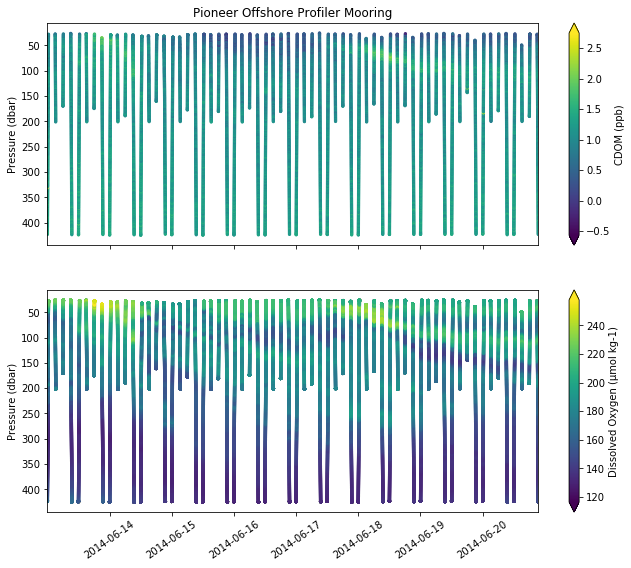

In [13]:
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, figsize=(11,9))
xc1 = ax1.scatter(np.array(FLORT_off_data['time']), FLORT_off_data['int_ctd_pressure'], c=FLORT_off_data['fluorometric_cdom'], s=5)
ax1.invert_yaxis()
ax1.set_xlabel('')
ax1.set_ylabel('Pressure (dbar)')
bar = fig.colorbar(xc1, ax=ax1, label='CDOM ({})'.format(FLORT_off_units['fluorometric_cdom'][0]), extend='both')
ax1.set_title('Pioneer Offshore Profiler Mooring')

xc2 = ax2.scatter(np.array(DO_off_data['time']), DO_off_data['int_ctd_pressure'], c=DO_off_data['dofst_k_oxygen_l2'], s=5)
ax2.invert_yaxis()
ax2.set_xlabel('')
ax2.set_ylabel('Pressure (dbar)')
bar = fig.colorbar(xc2, ax=ax2, label='Dissolved Oxygen ({})'.format(DO_off_units['dofst_k_oxygen_l2'][0]), extend='both')
plt.xticks(rotation=35)
# set the x limits to the min and max timestamp to get rid of extra white space in the graph
plt.xlim([np.nanmin(DO_off_data['time']), np.nanmax(DO_off_data['time'])]);

We need to remove the negative CDOM values in this dataset too.

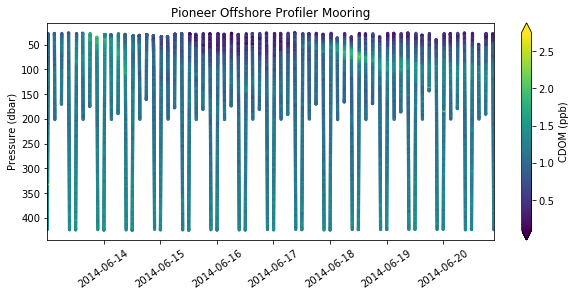

In [14]:
FLORT_off_data = remove_zeros(FLORT_off_data, FLORT_vars)

fig, ax1 = plt.subplots(figsize=(10,4))
xc1 = ax1.scatter(np.array(FLORT_off_data['time']), FLORT_off_data['int_ctd_pressure'], c=FLORT_off_data['fluorometric_cdom'], s=5)
ax1.invert_yaxis()
ax1.set_xlabel('')
ax1.set_ylabel('Pressure (dbar)')
bar = fig.colorbar(xc1, ax=ax1, label='CDOM ({})'.format(FLORT_off_units['fluorometric_cdom'][0]), extend='both')
ax1.set_title('Pioneer Offshore Profiler Mooring')
plt.xticks(rotation=35)
# set the x limits to the min and max timestamp to get rid of extra white space in the graph
plt.xlim([np.nanmin(FLORT_off_data['time']), np.nanmax(FLORT_off_data['time'])]);

## 3. Merge and export
Now let's work on merging and exporting the datasets as .csv files. First, we will downsample the data because these are very high-resolution datasets (about 1 sample every second). The function below calculates averages by 1 dbar depth bins by hour (so we retain the time series format).

In [15]:
def calculate_binned_averages(data_frame, pressure_var):
    # cut off the minutes and seconds in the time stamp
    data_frame['time'] = data_frame['time'].apply(lambda t: t.strftime('%Y-%m-%d %H'))

    # create a new column in the dataframe with pressure rounded to the nearest 1 dbar
    data_frame['Pressure Bin (dbar)'] = round(data_frame[pressure_var])

    # calculate depth-binned averages by time
    data_frame_binned = data_frame.groupby(['time', 'Pressure Bin (dbar)']).mean()
    
    return data_frame_binned

In [16]:
CTD_central_binned = calculate_binned_averages(CTD_central_data, 'ctdpf_ckl_seawater_pressure')
CTD_off_binned = calculate_binned_averages(CTD_off_data, 'ctdpf_ckl_seawater_pressure')

FLORT_central_binned = calculate_binned_averages(FLORT_central_data, 'int_ctd_pressure')
FLORT_off_binned = calculate_binned_averages(FLORT_off_data, 'int_ctd_pressure')

DO_central_binned = calculate_binned_averages(DO_central_data, 'int_ctd_pressure')
DO_off_binned = calculate_binned_averages(DO_off_data, 'int_ctd_pressure')

In [17]:
# merge the datasets for the Central Offshore Profiler Mooring on time and pressure bin, 
# and make sure the resulting dataframe is sorted by time
cp1 = pd.merge(CTD_central_binned, FLORT_central_binned, on=['time', 'Pressure Bin (dbar)'], how='outer')
cp1 = cp1.drop(columns=['int_ctd_pressure', 'ctdpf_ckl_seawater_pressure']) # drop extra pressure columns
central_profiler = pd.merge(cp1, DO_central_binned, on=['time', 'Pressure Bin (dbar)'], how='outer').reset_index()
central_profiler = central_profiler.drop(columns=['int_ctd_pressure']) # drop extra pressure column

# convert time from an object to a datetime
central_profiler['time'] = central_profiler['time'].apply(lambda t: dt.datetime.strptime(t, '%Y-%m-%d %H'))
central_profiler.head()

,time,Pressure Bin (dbar),ctdpf_ckl_seawater_temperature,practical_salinity,fluorometric_cdom,dofst_k_oxygen_l2
0,2014-06-13,27.0,20.319016,35.808158,0.4580,223.499472
1,2014-06-13,28.0,21.145130,35.859673,0.5496,219.061198
2,2014-06-13,29.0,19.737660,35.845178,0.2748,225.825939
3,2014-06-13,30.0,19.708775,35.846900,0.3664,225.717683
4,2014-06-13,31.0,19.669120,35.847862,0.5496,225.624747


In [18]:
# merge the datasets for the Offshore Profiler Mooring on time and pressure bin, 
# and make sure the resulting dataframe is sorted by time
off1 = pd.merge(CTD_off_binned, FLORT_off_binned, on=['time', 'Pressure Bin (dbar)'], how='outer')
off1 = off1.drop(columns=['int_ctd_pressure', 'ctdpf_ckl_seawater_pressure']) # drop extra pressure columns
central_offshore_profiler = pd.merge(off1, DO_off_binned, on=['time', 'Pressure Bin (dbar)'], how='outer').reset_index()
central_offshore_profiler = central_offshore_profiler.drop(columns=['int_ctd_pressure']) # drop extra pressure column

# convert time from an object to a datetime
central_offshore_profiler['time'] = central_offshore_profiler['time'].apply(lambda t: dt.datetime.strptime(t, '%Y-%m-%d %H'))
central_offshore_profiler.head()

,time,Pressure Bin (dbar),ctdpf_ckl_seawater_temperature,practical_salinity,fluorometric_cdom,dofst_k_oxygen_l2
0,2014-06-13,27.0,20.347053,35.711788,NaN,224.172636
1,2014-06-13,28.0,20.344581,35.723977,0.9480,224.322494
2,2014-06-13,29.0,20.316421,35.739662,1.0428,223.715594
3,2014-06-13,30.0,20.105200,35.728058,0.7584,222.330792
4,2014-06-13,31.0,20.077800,35.736449,0.8532,221.398101


Now that we have our downsampled and merged dataframe, let's plot just temperature and salinity for the Central Offshore Profiler Mooring again.

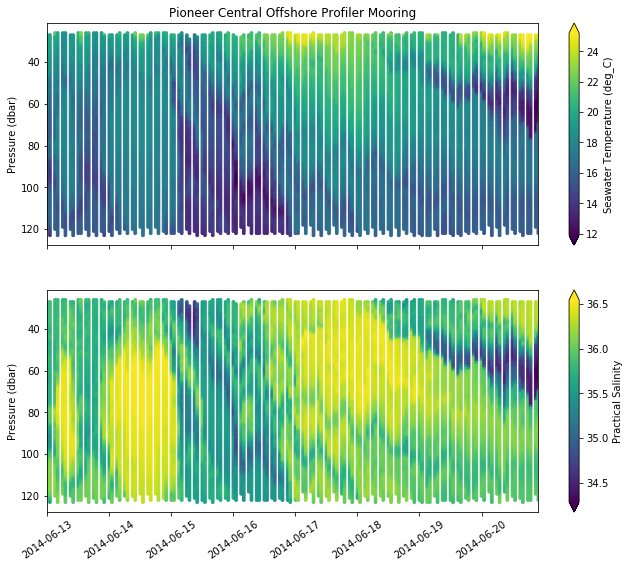

In [19]:
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, figsize=(11,9))
xc1 = ax1.scatter(np.array(central_profiler['time']), central_profiler['Pressure Bin (dbar)'], c=central_profiler['ctdpf_ckl_seawater_temperature'], s=8)
ax1.invert_yaxis()
ax1.set_xlabel('')
ax1.set_ylabel('Pressure (dbar)')
bar = fig.colorbar(xc1, ax=ax1, label='Seawater Temperature (deg_C)', extend='both')
ax1.set_title('Pioneer Central Offshore Profiler Mooring')

xc2 = ax2.scatter(np.array(central_profiler['time']), central_profiler['Pressure Bin (dbar)'], c=central_profiler['practical_salinity'], s=8)
ax2.invert_yaxis()
ax2.set_xlabel('')
ax2.set_ylabel('Pressure (dbar)')
bar = fig.colorbar(xc2, ax=ax2, label='Practical Salinity', extend='both')
plt.xticks(rotation=35)
# set the x limits to the min and max timestamp to get rid of extra white space in the graph
plt.xlim([np.nanmin(CTD_central_data['time']), np.nanmax(CTD_central_data['time'])]);

Now, let's rename the columns and export the dataframes as .csv files.

In [20]:
# rename the columns and add units
central_profiler = central_profiler.rename(columns={'sci_water_temp': 'Seawater Temperature (deg_C)',
                      'practical_salinity': 'Practical Salinity',
                      'fluorometric_cdom': 'CDOM ({})'.format(FLORT_central_units['fluorometric_cdom'][0]),
                      'dofst_k_oxygen_l2': 'Dissolved Oxygen ({})'.format(DO_central_units['dofst_k_oxygen_l2'][0])})

# export to csv
central_profiler.to_csv(os.path.join(save_dir, 'Theme4a_CP02PMCO_Pioneer_Central_Offshore_Profiler_Mooring.csv'), index=False)

In [21]:
# rename the columns and add units
central_offshore_profiler = central_offshore_profiler.rename(columns={'sci_water_temp': 'Seawater Temperature (deg_C)',
                      'practical_salinity': 'Practical Salinity',
                      'fluorometric_cdom': 'CDOM ({})'.format(FLORT_central_units['fluorometric_cdom'][0]),
                      'dofst_k_oxygen_l2': 'Dissolved Oxygen ({})'.format(DO_central_units['dofst_k_oxygen_l2'][0])})

# export to csv
central_offshore_profiler.to_csv(os.path.join(save_dir, 'Theme4a_CP04OSPM_Pioneer_Offshore_Profiler_Mooring.csv'), index=False)